<a href="https://colab.research.google.com/github/BuskovaH/mars-probe-simulation/blob/main/mars_probe_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulace oběžné dráhy
Na internetu je spousta simulací Keplerových zákonů: bohužel žádná z nich nenaplňuje moje potřeby - aby středoškolští studenti měli šanci vidět vnitřní kód simulace, a porozumět mu. Jedna věc je vidět pěkné obrázky nebo animace (k čemuž slouží již jiné dostupné nástroje, například [tato překrásná simulace z University of Colorado](https://phet.colorado.edu/sims/html/keplers-laws/latest/keplers-laws_all.html)), druhá věc je však vidět na vlastní oči že simulace je výsledkem matematiky které cílová skupina již rozumí.

První krok v každém programu v Pythonu je načtení případných externích knihoven: `numpy` (*num*erical *py*thon) je knihovna obsahující matematiku, která nám bude užitečná. Obvykle se používá její alias `np`, protože pět písmenek je moc na to aby je člověk psal opakovaně, pokud nemusí. `plt` součást knihovny `matplotlib.pyplot` je nejčastější objekt na výrobu grafů. `time` (čas) je knihovna která nám umožňuje měřit čas mezi událostmi v kódu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Následující blok kódu obsahuje fyzikální konstanty které budeme potřebovat: můžete si vyzkoušet záměnu M a m za hmotnosti v jiných systémech: Slunce-Země, Země-satelit, Země-Měsíc. (Pozor ale na ten poslední příklad: Měsíc je moc těžký na naši simulaci, která předpokládá, že velké těleso `M` je o hodně těžší než malé těleso `m`).

Nabízí se hra, kdy si studenti hodí kostkou, a hodnotu dosadí do `x_0` (vzdálenost od počátku), vynásobenou poloměrem většího tělesa. Pokud hodí 1, hází znovu, protože satelit ležící na povrchu planety není příliš zajímavá simulace. Týmy studentů (každý tedy s jinou počáteční hodnotou `x_0`) pak můžou soutěžit buď o nejkulatější orbitu (měření kulatosti momentálně není implementováno), nebo o to, kdo dokáže poslat sondu a povrch pod nejmenším úhlem. To musí udělat změnou `v_y0`, beze změny jiných parametrů.

In [2]:
#Nezapomeňte tento blok spustit znova když v něm uděláte nějaké změny!

jednotky = {"délka":"m", "hmotnost":"kg", "čas":"s"}
M = 6.4171*10**23 # hmotnost Marsu v kg
m = 100 # odhad hmotnosti sondy v kg
G = 6.67430*10**(-11) # gravitační konstanta v m^3/kg*s^2
Δt = 30 # doba mezi kroky simulace
kroky = 100000 # počet kroků simulace
poloměr = 33895000 # poloměr Marsu v metrech
atm_výška = 130000 # výška atmosféry v metrech

x_0 = 2*poloměr # počáteční pozice sondy od středu Marsu
y_0 = 0
v_x0 = 0  # počáteční rychlost sondy v m/s
v_y0 = 700 # abychom si problém prochu zjednodušili, je rychlost kolmá na směr
  # k planetě. Mimochodem, důsledkem toho je počáteční poloha vždy jedna
  # ze špiček elipsy.

# Matematika za výpočtem

## Vysvětlení

(Tuto sekci klidně přeskoč a vrať se k ní později.)

Aby se zdrojový kód lépe četl, obvykle uklízíme bloky které mají na práci jeden úkol do jedné funkce nebo jednoho objektu.

Technicky vzato, jediná důležitá funkce tady je `update_souřadnic`. Algoritmus zde použitý se jmenuje Eulerův, protože ho původně vymyslel Euler. Místo toho, abychom vymýšleli celou dráhu najednou, napodobíme přírodu: v každém bodě dráhy těleso pociťuje síly a má nějakou rychlost, a na jejich základě se posune do následujícího bodu. `update_zrychlení` je jen uklizený podstatný kus tohoto zjišťování: měří sílu, a na základě ní spočítá zrychlení. Technicky by to mohla být součást `update_souřadnic`, ale takto se bude kód snáze upravovat pokud bychom něco takového chtěli dělat v budoucnosti.

Počítače nemůžou počítat celou hladkou dráhu, ale pokud ji rozsekáme na dostatečně malé kousky, nikdo si nevšimne, že není nekonečně hladká.

Podívejme se tedy na simulaci v čase $t_1$. Satelit má nějakou rychlost. Už bychom měli tušit, že rychlost je vektor - má velikost a směr. To znamená, že ji můžeme rozložit do dvou směrů, třeba $v_x$ a $v_y$, směrů rovnoběžných s osami x a y. Podobně vyjádříme kde přesně je částice tím, že si zapíšeme její souřadnice $x$ a $y$.

Teď se podívejme, co se stane v čase $t_1$, který je velmi blízko času $t_2$. částice se musí "podívat," jestli se něco náhodou nezměnilo, od doby kdy byla v $t_1$, a přizpůsobí svůj pohyb novému prostředí. Eulerův algoritmus vypadá nějak takto:

```
zatímco běží simulace:
  zkontroluj zrychlení
  podle zrychlení změň rychlost
  podle rychlosti změň polohu
  (je dobrý nápad je někam zapisovat)
```

Jak zjistíme zrychlení? Zkombinujeme Newtonův první zákon:
\begin{equation}
\mathbf{F} = m\mathbf{a}
\end{equation}
a zákon gravitace:
\begin{equation}
F = \frac{GMm}{r^2}
\end{equation}
(v české literatuře občas místo $G$ pro gravitační konstantu narazíme na řecké písmeno kappa, $\kappa$)

Abychom si problém značně zjednodušili, budeme dělat že větší objekt se vůbec nehýbe a stojí ve středu vesmíru, čili na souřadnicích $[0,0]$. Když si můžeme dát střed souřadného systému kam chceme, proč ne sem. Zároveň to znamená, že vektor $\mathbf{r}$, který spojuje středy obou objektů, popisuje přesně směr kde je satelit.

Všimněme si jedné nešťastné věci: rovnice nahoře neobsahuje vůbec žádné vektory. Neříká nám tedy momentálně vůbec nic o tom, kam bude zrychlení ukazovat, což může být docela problém. Nemůžeme to vyřešit tím že zaměníme $r^2$ za $x^2 + y^2$ a zahodíme buď $x^2$ nebo $y^2$ - síla potřebuje vědět jak jsou tělesa daleko, ne jak daleko vypadají když si stoupneme na osu x nebo y a budeme na ně mžourat. Nasadíme důležitou techniku, známou jako podvod: Namísto toho, abychom se snažili z rovnice vytahat x- a y-složky síly, vynásobíme sílu tím, kolik z ní míří kterým směrem. Lze ukázat, že pro každý vektor $\mathbf{v}$ je výraz
\begin{equation}
\frac{\mathbf{v}}{|\mathbf{v}|}
\end{equation}
jednu jednotku dlouhý (ať už jsou jednotky metry, furlongy, nebo dokonce libry na palce) a ukazuje ve směru původního vektoru. $|\mathbf{v}|$ je tady velikost vektoru. Gravitační zákon s úpravou pro směr tak nazná malé úpravy:

\begin{equation}
\mathbf{F} = -\frac{GMm}{r^2}\frac{\mathbf{r}}{|r|}
\end{equation}

Jednotky zůstávají stejné, ale teď síla ukazuje nějakým směrem, a to dokonce tím správným. Kdybychom vynechali mínus, síla by byla odpudivá místo přitažlivé. Nebudu zde zacházet do detailů, zkuste si to na papíře pokud chcete.

Skvělá věc na programování je že nemusíme vytvářet jednu fraknenrovnici, ale můžeme výpočet rozdělit na postupné kroky - proto funkce `update_zrychlení` a `update_souřadnic` mohou nejdřív spočítat vektory v $x$, a pak v $y$ složce. Python by sice pro nás dokázal udělat obojí najednou, a bylo by to dokonce o fous rychlejší, ale kód by vypadal nepřehledně. V každém kroku tedy spočítáme sílu, protože víme, kde jsou částice. Pak spočítáme zrychlení jako $a = F/m$, následně rychlost jako $v = v_0 + a_x\Delta t$ a nakonec polohu $x = x_0 + v\Delta t$.

Protože nebudeme potřebovat předchozí pozice a rychlosti, můžeme je klidně v mezipaměti přepisovat těmi novými, což má na svědomí řádek $v_x = v_x + a_x\Delta t$ a jemu podobné. V programování naprosto normální ($v_x$ znamená pro počítač "chlíveček RAMky kde to číslo bydlí," takže mu nijak nevadí číslo použít a pak ho přepsat následujícím krokem. Rovnítko neslouží k porovnání, ale k přiřazení.)

Rozvažovala jsem jestli do našich výpočtů zahrnout odpor atmosféry. Odpor totiž závisí na velikosti rychlosti, čímž se malinko liší od gravitace (závislé pouze na poloze). Protože je atmosféra Marsu velmi řídká, je zde model tvrdé slupky s hladinou postačující. Je ale naprosto příšerný pro jakoukoliv jinou planetu: pokud chcete upravit svoji kopii pro modelování Země, asi ho budete muset nahradit nečím rozumnějším.

`kontrola_srážky` zastavuje simulaci když sonda narazí na povrch planety. Bez této funkce by si sonda vůbec nevšimla že má planeta povrch, a prostě by obíhala okolo středu planety.

`vykreslit` kreslí graf. Kód vypadá nechutně, a můžete taky v něm vidět, že jsem raději řekla Gemini AI ať ho napíše za mě. Barva dráhy začíná na tmavě modré a končí na žluté. Můžete si to zkusit upravit na jiné barevné schéma.

## Zdrojové kódy funkcí

In [8]:
def update_zrychlení(snímek):
    x, y, v_x, v_y = snímek
    r2 = x**2 + y**2
    r = np.sqrt(r2)
    v2 = v_x**2 + v_y**2
    v = np.sqrt(v2)
    gravF_x = -((G*M*m)/(r2))*(x/r)
    gravF_y = -((G*M*m)/(r2))*(y/r)
    odporF = 0.5*rho(r2)*v2*0.42*4
    F_x = gravF_x + odporF*v_x/v
    F_y = gravF_y + odporF*v_y/v
    a_x = F_x/m
    a_y = F_y/m
    return [a_x, a_y]


def update_souřadnic(snímek):
    x, y, v_x, v_y = snímek
    a_x, a_y = update_zrychlení(snímek)
    v_x = v_x + a_x*Δt
    v_y = v_y + a_y*Δt
    x = x + v_x*Δt
    y = y + v_y*Δt
    return [x, y, v_x, v_y]


def rho(r2): #this is stupid and I'm ashamed, the error is not huge for Mars though.
    tlak = 610 #Martian at ground level
    výška_atmosféry = 130000 #m
    grav_zrychlení = 3.72076 #m/s-2
    if r2 > poloměr+výška_atmosféry:
        return 0
    else:
        return tlak/(výška_atmosféry*grav_zrychlení)


def kontrola_srážky(snímek):
    x, y, v_x, v_y = snímek
    r2 = x**2 + y**2
    if r2 < poloměr**2:
        print("Sonda přistála s rychlostí " + str(np.sqrt(frame[2]**2 + frame[3]**2)))
        print("pod úhlem " + str(np.arctan2(v_y, v_x)*180/np.pi))
        return True
    else:
        return False


def vykreslit(snímky):
    lim = np.max(np.abs(snímky[:, 0:1]))
    # prompt: from x and y make a scatter plot that progressively colours each point.
    fig, ax = plt.subplots()
    sc = ax.scatter(snímky[:, 0], snímky[:, 1], c=np.arange(len(snímky[:,0])), s=5, cmap='viridis')
    center = ax.scatter(0, 0, c='red', s=10)
    kolečko = ax.add_patch(plt.Circle((0, 0), poloměr, color='red', fill=False))
    ax.set_xlabel(f"x [{jednotky['délka']}]")
    ax.set_ylabel(f"y [{jednotky['délka']}]")
    ax.set_ylim(-lim, lim)
    ax.set_xlim(-lim, lim)
    ax.set_title("Simulace dráhy m okolo M")
    fig.colorbar(sc, label="Časový krok")
    plt.show()


def s_to_dhms(seconds):
    days = int(seconds/86400)
    hours = int((seconds-(days*86400))/3600)
    minutes = int((seconds-(days*86400)-(hours*3600))/60)
    seconds = int(seconds-(days*86400)-(hours*3600)-(minutes*60))
    return days, hours, minutes, seconds

## Začátek běhu programu

## Vysvětlení

Nejdřív si program zapíše čas kdy začal běžet.
Následně si přepíše počáteční rychlost a polohu do formy, které bude rozumět zbytek programu.
`for něco in range(počet)` je řádka, která bude počet-krát opakovat příkazy které jsou v bezprostředně následujících odsazených řádkách. Musí si ale odpočítávat, kolikrát to má udělat: počet opakování který proběhl zapisuje právě do `něco`, což je pro nás proměnná `i`.

V samotném `for` cyklu si vezme snímek situace který dostal naposledy, a přepíše ho krokem následujícím (jak dlouhá doba mezi kroky uplynula je v druhém bloku kódu nahoře značeno jako $\Delta t$). Pak si nové hodnoty souřadnic a poloh uloží na konec seznamu, podobně jako analogový fotoaparát ukládá film běžce postupně na políčka kinofilmu jako jednotlivé snímky. Každý cyklus se také podívá, jestli náhodou sonda nepřistála na povrch - pokud ano, simulace končí.

Řádek `snímky = np.array(snímky)` jen přeuloží výsledek z datové struktury seznam (list) do datové struktury pole (array). Dá se tomu vyhnout, ale okolní kód je díky tomu kompaktnější: `Append` (přilož na konec) je rychlejší a přátelštější k RAM pro seznamy, `plot` (vykresli) se zase chová lépe pro pole.

`mid = time.time()` a `end = time.time()` dělají prakticky totéž, zapisují do sebe kdy počítač narazil na ten řádek kódu. To abychom věděli, jak dlouho trvalo spočítat dráhu, a jak dlouho trvalo ji ukázat aby byla stravitelná pro člověka.

## Kód

Simulovaný čas 34 dní 17 hodin 20 minut 30 sekund
Průměrná rychlost 0.9 km/s
Výpočet trval 1.488 sekund, s 0.008 sekundami overhead.


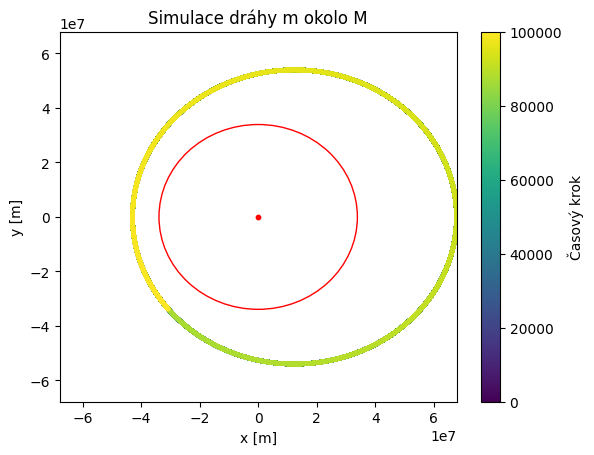

Vykreslení grafu trvalo 2.226 sekund


In [9]:
# Pokud program spouštíte poprvé za session, musíte seběhnout všechny bloky.
# Potom můžete už spouštět ty kterým jste udělali změny, a tento blok.

start = time.time()

snímek = [x_0, y_0, v_x0, v_y0]
snímky = [snímek]

for i in range(kroky):
    snímek = update_souřadnic(snímek)
    snímky.append(snímek)
    if kontrola_srážky(snímek) == True:
      break

snímky = np.array(snímky)

mid = time.time()

days, hours, minutes, seconds = s_to_dhms(len(snímky[:,0])*Δt)
print("Simulovaný čas", str(days), "dní", str(hours), "hodin", str(minutes), "minut", str(seconds), "sekund")
print("Průměrná rychlost", np.round(np.mean(np.sqrt(snímky[:, 2]**2 + snímky[:, 3]**2))/1000, 1), "km/s")

end = time.time()
print("Výpočet trval", np.round(mid-start, 3), "sekund, s", np.round(end-mid, 3), "sekundami overhead.")

vykreslit(snímky)

plot_time = time.time()
print("Vykreslení grafu trvalo", np.round(plot_time-end, 3), "sekund")